<a href="https://colab.research.google.com/github/Rose-Kimu/Automata-Machine/blob/main/Testing_Linear_Regressors_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import patsy

import itertools as it
import collections as co
import functools as ft
import os.path as osp

import glob
import textwrap

# finally, a better idiom for warnings
import sklearn, warnings
warnings.filterwarnings('ignore',
                        category=FutureWarning,
                        module='sklearn')

warnings.filterwarnings('ignore',
                        category=FutureWarning,
                        module='tensor*')

# if the warnings get overwhelming,
# you can re-disable with these original lines:
#import warnings
#warnings.filterwarnings("ignore")

# and for the really aggressive warnings:
# some warnings are stubborn in the extreme, we don't want
# them in the book
#def warn(*args, **kwargs):  pass
#warnings.warn = warn

# config related
np.set_printoptions(precision=4,
                    suppress=True)
pd.options.display.float_format = '{:20,.4f}'.format

# there are good reasons *NOT* to do this in any real production code
# for our purposes (writing a book with completely reproducable output)
# this *is* what we want
np.random.seed(42)

# default is [6.4, 4.8]  (4:3)
mpl.rcParams['figure.figsize'] = [4.0, 3.0]

# turn on latex tables
pd.set_option('display.latex.repr', True)
# monkey-patch for centering Out[] DataFrames
def _repr_latex_(self):
    return "{\centering\n%s\n\medskip}" % self.to_latex()
pd.DataFrame._repr_latex_ = _repr_latex_

# only used once
markers = it.cycle(['+', '^', 'o', '_', '*', 'd', 'x', 's'])


# handy helper for displaying stuff
from IPython.display import Image

#
# sklearn's packaging is very java-esque.  :(
#
from sklearn import (cluster,
                     datasets,
                     decomposition,
                     discriminant_analysis,
                     dummy,
                     ensemble,
                     feature_selection as ftr_sel,
                     linear_model,
                     metrics,
                     model_selection as skms,
                     multiclass as skmulti,
                     naive_bayes,
                     neighbors,
                     pipeline,
                     preprocessing as skpre,
                     svm,
                     tree)


# the punch line is to predict for a large grid of data points
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
def plot_boundary(ax, data, tgt, model, dims, grid_step = .01):
    # grab a 2D view of the data and get limits
    twoD = data[:, list(dims)]
    min_x1, min_x2 = np.min(twoD, axis=0) + 2 * grid_step
    max_x1, max_x2 = np.max(twoD, axis=0) - grid_step


    # make a grid of points and predict at them
    xs, ys = np.mgrid[min_x1:max_x1:grid_step,
                      min_x2:max_x2:grid_step]
    grid_points = np.c_[xs.ravel(), ys.ravel()]
    # warning:  non-cv fit
    preds = model.fit(twoD, tgt).predict(grid_points).reshape(xs.shape)

    # plot the predictions at the grid points
    ax.pcolormesh(xs,ys,preds,shading='auto',cmap=plt.cm.coolwarm)
    ax.set_xlim(min_x1, max_x1)#-grid_step)
    ax.set_ylim(min_x2, max_x2)#-grid_step)

def plot_separator(model, xs, ys, label='', ax=None):
    ''' xs, ys are 1-D b/c contour and decision_function
        use incompatible packaging '''
    if ax is None:
        ax = plt.gca()

    xy = np_cartesian_product(xs, ys)
    z_shape = (xs.size, ys.size) # verus shape[0]?
    zs = model.decision_function(xy).reshape(z_shape)

    contours = ax.contour(xs, ys, zs,
                          colors='k', levels=[0],
                          linestyles=['-'])
    fmt = {contours.levels[0] : label}
    labels = ax.clabel(contours, fmt=fmt, inline_spacing=10)
    [l.set_rotation(-90) for l in labels]

def high_school_style(ax):
    ' helper to define an axis to look like a typical school plot '
    ax.spines['left'].set_position(('data', 0.0))
    ax.spines['bottom'].set_position(('data', 0.0))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    def make_ticks(lims):
        lwr, upr = sorted(lims) #x/ylims can be inverted in mpl
        lwr = np.round(lwr).astype('int') # can return np objs
        upr = np.round(upr).astype('int')
        if lwr * upr < 0:
            return list(range(lwr, 0)) + list(range(1,upr+1))
        else:
            return list(range(lwr, upr+1))

    import matplotlib.ticker as ticker
    xticks = make_ticks(ax.get_xlim())
    yticks = make_ticks(ax.get_ylim())

    ax.xaxis.set_major_locator(ticker.FixedLocator(xticks))
    ax.yaxis.set_major_locator(ticker.FixedLocator(yticks))

    ax.set_aspect('equal')

def get_model_name(model):
    ' return name of model (class) as a string '
    return str(model.__class__).split('.')[-1][:-2]

def rdot(w,x):
    ' apply np.dot on swapped args '
    return np.dot(x,w)

from sklearn.base import BaseEstimator, ClassifierMixin
class DLDA(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass

    def fit(self, train_ftrs, train_tgts):
        self.uniq_tgts = np.unique(train_tgts)
        self.means, self.priors = {}, {}

        self.var  = train_ftrs.var(axis=0) # biased
        for tgt in self.uniq_tgts:
            cases = train_ftrs[train_tgts==tgt]
            self.means[tgt]  = cases.mean(axis=0)
            self.priors[tgt] = len(cases) / len(train_ftrs)
        return self

    def predict(self, test_ftrs):
        disc = np.empty((test_ftrs.shape[0],
                         self.uniq_tgts.shape[0]))
        for tgt in self.uniq_tgts:
            # technically, the maha_dist is sqrt() of this:
            mahalanobis_dists = ((test_ftrs - self.means[tgt])**2 /
                                 self.var)
            disc[:,tgt] = (-np.sum(mahalanobis_dists, axis=1) +
                           2 * np.log(self.priors[tgt]))
        return np.argmax(disc,axis=1)


def plot_lines_and_projections(axes, lines, points, xs):
    data_xs, data_ys = points[:,0], points[:,1]
    mean = np.mean(points, axis=0, keepdims=True)
    centered_data = points - mean

    for (m,b), ax in zip(lines, axes):
        mb_line = m*xs + b
        v_line = np.array([[1, 1/m if m else 0]])

        ax.plot(data_xs, data_ys, 'r.') # uncentered
        ax.plot(xs, mb_line, 'y')      # uncentered
        ax.plot(*mean.T, 'ko')

        # centered data makes the math easier!
        # this is length on yellow line from red to blue
        # distance from mean to projected point
        y_lengths = centered_data.dot(v_line.T) / v_line.dot(v_line.T)
        projs = y_lengths.dot(v_line)

        # decenter (back to original coordinates)
        final = projs + mean
        ax.plot(*final.T, 'b.')

        # connect points to projections
        from matplotlib import collections as mc
        proj_lines = mc.LineCollection(zip(points,final))
        ax.add_collection(proj_lines)

        hypots = zip(points, np.broadcast_to(mean, points.shape))
        mean_lines = mc.LineCollection(hypots, linestyles='dashed')
        ax.add_collection(mean_lines)

# adding an orientation would be nice
def sane_quiver(vs, ax=None, colors=None, origin=(0,0)):
    '''plot row vectors from origin'''
    vs = np.asarray(vs)
    assert vs.ndim == 2 and vs.shape[1] == 2  # ensure column vectors
    n = vs.shape[0]
    if not ax: ax = plt.gca()

    orig_x, orig_y = origin
    xs = vs.T[0]  # column to rows, row[0] is xs
    ys = vs.T[1]

    # highly annoying:  quiver doesn't broadcast anymore (?)
    orig_x = np.full_like(xs, orig_x)
    orig_x = np.full_like(xs, orig_x)

    props = {"angles":'xy', 'scale':1, 'scale_units':'xy'}
    ax.quiver(orig_x, orig_y, xs, ys, color=colors, **props)

    ax.set_aspect('equal')
    # ax.set_axis_off()
    _min, _max = min(vs.min(), 0) -1, max(0, vs.max())+1
    ax.set_xlim(_min, _max)
    ax.set_ylim(_min, _max)

def reweight(examples, weights):
    ''' convert weights to counts of examples using approximately two
        significant digits of weights.

        there are probably a 100 reasons not to do this like this.
        top 2:
          1.  boosting may require more precise values (or using randomization)
              to keep things unbiased
          2.  this *really* expands the dataset to a significant degree
              (wastes resources)
    '''
    from math import gcd
    from functools import reduce

    # who needs repeated the least?
    min_wgt = min(weights)
    min_replicate = 1 / min_wgt # e.g., .25 -> 4

    # compute naive duplication to 2 decimal places
    counts = (min_replicate * weights * 100).astype(np.int64)

    # trim duplication if we can
    our_gcd = reduce(gcd, counts)
    counts = counts // our_gcd

    # repeat is picky about type
    return np.repeat(examples, counts, axis=0)

#examples = np.array([1, 10, 20])
#weights  = np.array([.25, .33, 1-(.25+.33)])
# print(pd.Series(reweight(examples, weights)))

def enumerate_outer(outer_seq):
    '''repeat the outer idx based on len of inner'''
    return np.repeat(*zip(*enumerate(map(len, outer_seq))))

def np_array_fromiter(itr, shape, dtype=np.float64):
    ''' helper since np.fromiter only does 1D'''
    arr = np.empty(shape, dtype=dtype)
    for idx, itm in enumerate(itr):
        arr[idx] = itm
    return arr

# how do you figure out arcane code?
# work inside out, small inputs, pay attention to datatypes.
# try outter and righter calls with simpler inputs
# read docs *in conjunction with* experiments
# [the docs rarely make sense - to me - in the abstract until I try
#  examples while reading them]

# the difference with a "raw" np.meshgrid call is we stack these up in
# two columns of results (i.e., we make a table out of the pair arrays)
def np_cartesian_product(*arrays):
    ''' some numpy kung-fu to produce all
        possible combinations of input arrays '''
    ndim = len(arrays)
    return np.stack(np.meshgrid(*arrays), axis=-1).reshape(-1, ndim)

# replacement for tsplot is happiest with
# "tidy" data
# tidying the numpy array is a bit of a pain
# xarray is designed to do this "natively" but
# i don't want to introduce that dependency
# [seems like there could be a better broadcasting
#  solution to this]
def sk_graph_to_tidy(train_test_scores, # y values
                     eval_points,       # x values
                     eval_label,        # x column name
                     num_folds):        # could be inferred
    train_scores, test_scores = train_test_scores
    # humph, didn't know np_cartesian was order sensitive
    labels = np_cartesian_product(eval_points,
                                  [0,1], # surrogates for train/test
                                  np.arange(num_folds))
    score = np.concatenate([train_scores.flatten(),
                            test_scores.flatten()], axis=0)

    df = pd.DataFrame.from_records(labels)
    df.columns = [eval_label, 'set', 'fold']
    df.set = df.set.replace({0:'Train', 1:'Test'})
    df['score'] = score
    return df


In [ ]:
# stand-alone code
from sklearn import (datasets, neighbors,model_selection as skms,linear_model, metrics)

diabetes = datasets.load_diabetes()
tts = skms.train_test_split(diabetes.data, diabetes.target,test_size=.25)

(diabetes_train, diabetes_test,
diabetes_train_tgt, diabetes_test_tgt) = tts

models = {'kNN': neighbors.KNeighborsRegressor(n_neighbors=1),
'linreg' : linear_model.LinearRegression()}


for name, model in models.items():
  fit = model.fit(diabetes_train, diabetes_train_tgt)
  preds = fit.predict(diabetes_test)
  score = np.sqrt(metrics.mean_squared_error(diabetes_test_tgt, preds))
  print("{:>6s} : {:0.2f}".format(name,score))

   kNN : 77.69
linreg : 53.33


In [ ]:
import timeit, sys
import functools as ft
import memory_profiler
from mlwpy import *

def knn_go(train_ftrs, test_ftrs, train_tgt):
knn = neighbors.KNeighborsRegressor(n_neighbors=3)
fit
= knn.fit(train_ftrs, train_tgt)
preds = fit.predict(test_ftrs)
def lr_go(train_ftrs, test_ftrs, train_tgt):
linreg = linear_model.LinearRegression()
fit
= linreg.fit(train_ftrs, train_tgt)
preds = fit.predict(test_ftrs)
def split_data(dataset):
split = skms.train_test_split(dataset.data,
dataset.target,
test_size=.25)
return split[:-1] # don't need test tgt
def msr_time(go, args):
call = ft.partial(go, *args)
tu = min(timeit.Timer(call).repeat(repeat=3, number=100))
print("{:<6}: ~{:.4f} sec".format(go.__name__, tu))
def msr_mem(go, args):
base = memory_profiler.memory_usage()[0]
mu = memory_profiler.memory_usage((go, args),
max_usage=True)[0]
print("{:<3}: ~{:.4f} MiB".format(go.__name__, mu-base))


if __name__ == "__main__":
which_msr = sys.argv[1]
which_go = sys.argv[2]
msr = {'time': msr_time, 'mem':msr_mem}[which_msr]
go = {'lr' : lr_go, 'knn': knn_go}[which_go]
sd = split_data(datasets.load_iris())
msr(go, sd)

In [ ]:
N = 20
ftr = np.linspace(-10, 10, num=N)
# ftr values
tgt = 2*ftr**2 - 3 + np.random.uniform(-2, 2, N) # tgt = func(ftr)

(train_ftr, test_ftr,
train_tgt, test_tgt) = skms.train_test_split(ftr, tgt, test_size=N//2)
display(pd.DataFrame({"ftr":train_ftr,
"tgt":train_tgt}).T)

<ipython-input-1-bd5686fdc492>:54: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return "{\centering\n%s\n\medskip}" % self.to_latex()


,0,1,2,3,4,5,6,7,8,9
ftr,6.8421,-3.6842,5.7895,3.6842,-10.0000,-8.9474,-0.5263,-1.5789,8.9474,0.5263
tgt,90.8510,23.0858,62.7845,23.0811,198.4301,155.5003,-1.1359,1.3355,156.7804,-4.4436


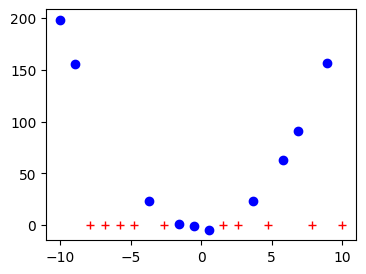

In [ ]:
plt.plot(train_ftr, train_tgt, 'bo')
plt.plot(test_ftr,
np.zeros_like(test_ftr), 'r+');

In [ ]:
# note: sklearn *really* wants 2D inputs (a table)
# so we use rehape here.
sk_model = linear_model.LinearRegression()
sk_model.fit(train_ftr.reshape(-1, 1), train_tgt)
sk_preds = sk_model.predict(test_ftr.reshape(-1, 1))
sk_preds[:3]

array([63.359 , 78.5005, 87.5853])

In [ ]:
x = input('Enter')
y = input ('Enter second value')

n = y - ( 2*x**2 - 3)
print(n)



Enter-3.68
Enter second value22.38


TypeError: ignored

In [ ]:

x = float(input('Enter a value: '))  # Convert input to a float
y = float(input('Enter a second value: '))  # Convert input to a float

n = y - ((2 * (x**2 ))- 3)
print(n)


In [ ]:
ftr = 2.39
tgt = 2*ftr**2 - 3 + np.random.uniform(-2, 2, N)
print(tgt)

In [ ]:
print('Hello world')